In [1]:
from rnamodif.architectures.rodan_event import RodanEvent
from rnamodif.data_utils.dataloading_events import event_datamodule

from rnamodif.data_utils.split_methods import get_kfold_splits, get_fullvalid_split, get_valid_portions
import pytorch_lightning as pl
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import ModelCheckpoint

#TODO low GPU utilization - fix bottlenecks
dm = event_datamodule(
    readers_split_config={
        'pos':[
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/m6A_33', 'train_portion':0.8},
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB090763_m6A', 'train_portion':0.0},
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/m6A_10', 'train_portion':0.0},
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/m6A_5', 'train_portion':0.0},
        ],
        'neg':[
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/m6A_0', 'train_portion':0.8},
            {'reader_path':'/home/jovyan/taiyaki_test/mapped_reads_2/RNAAB089716_m6A_UNM', 'train_portion':0.0},
        ],
    },
    batch_size=64, 
    workers=2,
    window=1024, #4096
    valid_limit = 5000,
)


model = RodanEvent(lr=1e-3, warmup_steps=3000, vocab_map=dm.vocab_map)

experiment_name = 'm6a_0v33_event_modp_1'
checkpoint_callback = ModelCheckpoint(
    dirpath=f"/home/jovyan/RNAModif/rnamodif/checkpoints_pl/{experiment_name}", 
    save_top_k=2, 
    monitor="valid_loss", 
    save_last=True, 
    save_weights_only=False
)

logger = CometLogger(api_key="TEVQbgxxvilM1WdTyqZLJ57ac", project_name='RNAModif', experiment_name=experiment_name) 
trainer= pl.Trainer(
    max_steps = 1000000, logger=logger, accelerator='gpu',
    auto_lr_find=False, val_check_interval=500,  
    log_every_n_steps=500, benchmark=True, precision=16,
    callbacks=[checkpoint_callback], #commented out = no saving
    # profiler='simple')
    # resume_from_checkpoint=f'/home/jovyan/RNAModif/rnamodif/checkpoints_pl/{experiment_name}/last.ckpt'
)

# trainer.fit(model, dm)

CometLogger will be initialized in online mode
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


vocab ok


/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return bound(*args, **kwds)
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return bound(*args, **kwds)
/home/jovyan/my-conda-en

TGXCGXXGXTCGCGCTXXT


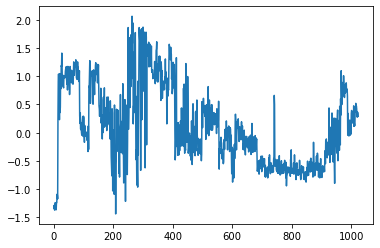

In [2]:
from matplotlib import pyplot as plt

dm.setup()
batch = next(iter(dm.train_dataloader()))
X = batch[0]
y = batch[1]
plt.plot(X[0].flatten())
print(y[0])

In [51]:
%%time
import torch
vocab_map = {'A':0,'C':1,'G':2,'T':3}
def setup_vocab_map_for_ctc(vocab_map):
    new_vocab = {}
    new_vocab['N'] = 0 #unused
    for k,v in vocab_map.items():
        new_vocab[k] = vocab_map[k]+1
    new_vocab['X'] = 5 #5 because i torch.cat in forward, mod_pred is last place
    return new_vocab

def greedy_ctc_decode(y_pred):
    # Apply softmax and find the argmax for each time step
    decoded = y_pred.argmax(2)
    
    # Collapse duplicate predictions and remove the blank label
    decoded_seqs = []
    for seq in decoded:
        decoded_seq = [seq[0].item()]
        for label in seq[1:]:
            if label != decoded_seq[-1] and label != 0:
                decoded_seq.append(label.item())
        decoded_seqs.append(decoded_seq)
    
    return decoded_seqs
vocab_map = setup_vocab_map_for_ctc(vocab_map)

def compute_loss(output, y):
    output_size = output.size()
    signal_len = output_size[0]
    batch_size = output_size[1]
    signal_lengths = torch.tensor(signal_len).repeat(batch_size)
    label_lengths = torch.tensor([len(label) for label in y])
    numericalized_labels = torch.tensor([vocab_map[char] for label in y for char in label])
    
    loss = torch.nn.functional.ctc_loss(
        output, 
        numericalized_labels,
        signal_lengths, 
        label_lengths, 
        reduction='mean', 
        blank=0 #label for the N character
    )
    print(loss)
    return loss
        
def compute_loss_pusher(output, y):
    output_size = output.size()
    signal_len = output_size[0]
    batch_size = output_size[1]
    signal_lengths = torch.tensor(signal_len).repeat(batch_size)
    label_lengths = torch.tensor([len(label) for label in y])
    numericalized_labels = torch.tensor([vocab_map[char] if char != 'X' else vocab_map['A'] for label in y for char in label])
    # numericalized_labels = torch.tensor([vocab_map[char] for label in y for char in label])
    pos_indicies = torch.tensor([1 if 'X' in l else 0 for i,l in enumerate(y)]).float()
    vals, _ = torch.max(output[:,:,-1], dim=0)
    print(vals.size())
    loss = torch.nn.functional.ctc_loss(
        output, 
        numericalized_labels,
        signal_lengths, 
        label_lengths, 
        reduction='mean', 
        blank=0 #label for the N character
    )
    ce_loss = torch.nn.functional.binary_cross_entropy(vals, pos_indicies)
    
    return loss + ce_loss     


# res = compute_loss(torch.rand(100, 64, 5), [s[:50] for s in batch[1]])

res = compute_loss_pusher(torch.rand(100, 64, 5), batch[1])


torch.Size([64])
CPU times: user 65.3 ms, sys: 20.7 ms, total: 86 ms
Wall time: 5.91 ms


In [ ]:
seq = batch[1][0]
print(seq)
seq.find('X')

In [ ]:
import itertools

def generate_variations(seq):
    num_as = seq.count('A')
    num_replacements = int(0.25 * num_as)
    variations = set()
    variations = []
    
    idxs = [pos for pos, char in enumerate(seq) if char == 'A']
    for combo in itertools.combinations(range(num_as), num_replacements):
        new_seq = list(seq)
        for order in combo:
            new_seq[idxs[order]] = 'X'
        variations.append(''.join(new_seq))

    return variations

generate_variations('ACTGAATGA')


In [ ]:
'XXTTXXXT'.replace('X','A')